# Debug Missmatch of Maximum Retransmission

In [2]:
import random
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
beta = 0.6
# gamma = 0.2996949554421148
gamma = 0.234
alpha = 2
timeDivider = 100
rtt = 124.4275
rttvar = 12.692700103043293
rto = 175.1967
rxMaxList = [1, 2, 3, 4, 5]

## Theoretical Method

### Calculate S by checking each possible retransmission value

In [4]:
def calc_delvy_rate_expect(gamma, rxMax):
    # calculated
    return 1 - gamma**rxMax


def calc_delay_expect(gamma, rtt, rto, rxMax):
    if gamma == 1:
        return rtt + rto * (rxMax-1)
    numerator = rtt + rto * (gamma * (1-gamma ** (rxMax-1)))/(1-gamma) - (rtt + (rxMax-1)*rto)*(gamma**rxMax)
    denominator = 1 - gamma ** rxMax
    return numerator / denominator

def calc_utility(delay, delvy, alpha, beta, timeDivider):
    r = (beta**(delay/timeDivider)) * (delvy**alpha)
    return r

In [5]:
delay_theory = [calc_delay_expect(gamma, rtt, rto, rxMax) for rxMax in rxMaxList]
delvy_theory = [calc_delvy_rate_expect(gamma, rxMax) for rxMax in rxMaxList]

utilityRxList = [calc_utility(delay, delvy, alpha, beta, timeDivider) for delay, delvy in zip(delay_theory, delvy_theory)]
bstUtilityId = np.argmax(utilityRxList)
bestMarker = [""] * len(utilityRxList)
bestMarker[bstUtilityId] = "best"
bestUtility = utilityRxList[bstUtilityId]

utilityDf = pd.DataFrame({"txTimes":rxMaxList, "delay": delay_theory, "delivery": delvy_theory, "utility": utilityRxList, "best": bestMarker})
utilityDf.set_index("txTimes")

,delay,delivery,utility,best
txTimes,,,,
1,124.427500,0.766000,0.310754,
2,157.649565,0.945244,0.399341,
3,171.125377,0.987187,0.406593,best
4,175.839687,0.997002,0.404850,
5,177.332112,0.999298,0.403628,


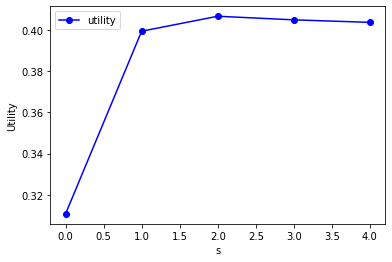

In [6]:
plt.plot(utilityDf.index, utilityDf.utility, 'b-o', label="utility")
plt.xlabel("s")
plt.ylabel("Utility")
plt.legend()

### Calculating the Q table using the SMDP method

In [7]:
def calc_qij_approx_norm(beta, mean, var, rx, timeDivider):
    """
    qij is the expected reward discount between state i and state j
    Channel delay is a Gaussian

    But !!!!! var here is not variance. According to RFC, var = E[|rtt - mean|]
    var is more a standard deviation. Maybe they want to use var2 to represent the variance.
    rto is approximated by mean + 4 * std 

    """
    # var *= var

    rto = mean + 4*var
    # mean is the average time gap between state i and state j, which is 
    # mean = (j-i) * rto
    mean = (rto*rx)

    var *= rx

    segments = 1000
    # sigma = math.sqrt(var) # three sigma rule
    sigma = var
    # sample from [-sigma_multi*sigma, +sigma_multi*sigma]+mean
    sigma_multi = 3
    dx = 2*sigma_multi*sigma / segments
    x = np.linspace(mean-sigma_multi*sigma, mean+sigma_multi*sigma, segments)
    beta_exp_x = np.power(beta, x/timeDivider)
    pdf = norm.pdf(x, loc=mean, scale=sigma)
    qij = sum(beta_exp_x * pdf * dx)
    return qij


In [8]:
def calc_V_theo_norm(gamma, timeDivider, alpha, beta, mean, var, smax):
    """
    Pay great attention here, var != var(RTT). In RFC, var ~ \Exp[RTT - RTT_mean]
    """
    channelDelay = mean
    channelRTO = mean + 4 * var
    utility = []
    for s in range(1, smax):
        delay_s = calc_delay_expect(gamma, channelDelay, channelDelay + 4*var, s)
        deliveryRate_s = calc_delvy_rate_expect(gamma, s)
        utility_s = calc_utility(
            delay_s, deliveryRate_s, alpha, beta, timeDivider)
        utility.append(utility_s)
    s = np.argmax(utility)+1  # our s is 1-index
    utility_s = utility[s-1]
    AB = np.zeros((s, smax))  # the [A, B] matrix in mathematical model
    qij_list = np.zeros(smax+1)
    for drx in range(1, smax+1):
        qij_list[drx] = calc_qij_approx_norm(beta, mean, var, drx, timeDivider)

    # qij_list /= sum(qij_list)

    for col in range(1, smax+1):
        for row in range(0, s):
            if row+col < smax:
            # if row + col <= s:
                AB[row, row+col] = qij_list[col]
    
    # print("qij_list", qij_list.shape)
    # for row in range(0, s):
    #     AB[row, row+1] = qij_list[1]

    A = AB[:, :s]
    B = AB[:, s:]

    delayCalc = lambda rx: channelDelay + (rx-1) * channelRTO
    h = np.asarray([[utility_s]*(smax - s)]).T
    g = np.asarray([[calc_utility(delayCalc(rx), 1, alpha,
                   beta, timeDivider) for rx in range(1, s+1)]]).T
    v_threory = np.linalg.pinv(
        np.eye(s)-gamma*A).dot(B.dot(h) + (1-gamma)*g)
    v = np.concatenate([v_threory[:, 0], h[:, 0]])
    return v, s, qij_list

In [9]:
def calc_qij_approx(alpha, beta, mean, var, rx, timeDivider):
    return calc_utility(mean + (mean+var*4)*(rx-1), 1, alpha, beta, timeDivider) / calc_utility(mean, 1, alpha, beta, timeDivider)

In [10]:
v_theory, s_theory, qij_list = calc_V_theo_norm(gamma, 100, alpha, beta, rtt, rttvar, 20)
pktSeenProb = [(1-gamma)*(gamma ** (rxMax-1)) for rxMax in rxMaxList]

SMDPUtilDf = pd.DataFrame({"v-SMDP": v_theory[:len(rxMaxList)], "pktSeenProb":pktSeenProb, "qij":qij_list[:len(rxMaxList)], "qij_approx": [calc_qij_approx(alpha, beta, rtt, rttvar, rx, timeDivider) for rx in rxMaxList]})
print(s_theory)
SMDPUtilDf

3


,v-SMDP,pktSeenProb,qij,qij_approx
0,0.497730,0.766000,0.000000,1.000000
1,0.315565,0.179244,0.407959,0.408625
2,0.349993,0.041943,0.167728,0.166974
3,0.406592,0.009815,0.069242,0.068230
4,0.406592,0.002297,0.028702,0.027880


Debug qij (pass)

In [11]:
drxList = list(range(1,5))
qij_func = [0]*len(drxList)
qij_manual = [0] * len(drxList)
for i, drx in enumerate(drxList):
    qij_func[i] = calc_qij_approx_norm(beta, rtt, rttvar, drx, timeDivider)
    qij_manual[i] = beta ** (drx*rto/timeDivider)

qijDf = pd.DataFrame({"drx": drxList, "qij-from function":qij_func, "qij-manual approx": qij_manual})
qijDf.set_index("drx")
qijDf


,drx,qij-from function,qij-manual approx
0,1,0.407959,0.408628
1,2,0.167728,0.166977
2,3,0.069242,0.068232
3,4,0.028702,0.027881


Debug Reward

In [12]:
def gValCalc(txTimes, pktDelay, rtt, rttvar, txMax, sysDelay, sysDelvy, sysUtil, gamma):
    if txTimes <= txMax:
        """
        option 1 - not good. 
        If delay is large, even delivery = 1, utility is still low.
        Accepting a long delay pkt will not significantly reduce system utility, but even increase it 
        because the witness probability is small. 
        """
        # gVal = calc_utility(pktDelay, 1, alpha, beta, timeDivider)
        """
        option 2
        """
        # pktDelvy = calc_delvy_rate_expect(gamma, txTimes)
        pktDelvy = 1
        # pktDelay = calc_delay_expect(gamma, rtt, rtt+4*rttvar, txTimes)
        pktDelay = (rtt + 4 * rttvar) * (txTimes-1) + rtt
        gVal = calc_utility(pktDelay, pktDelvy, alpha, beta, timeDivider)
    else:
        gVal = 0
    return gVal

def hValCalc(txTimes, delay, rtt, rttvar, txMax, sysDelay, sysDelvy, sysUtil, gamma):
    if txTimes > txMax:
        hVal = sysUtil
    else:
        hVal = 0
    return hVal

def witnessProb(txTimes, gamma, txMax): # txMax, maximum allowed transmission times (inclusive)
    if txTimes <= 0:
        print("we shouldn't seen a pkt with txTimes = 0.")
    if txTimes <= txMax:
        # delivered pkt
        p = (1-gamma) * (gamma** (txTimes-1))
    else:
        # dropped pkt
        p = gamma ** txMax
    return p

sysDelay = delay_theory[bstUtilityId]
sysDelvy = delvy_theory[bstUtilityId]
sysUtil = calc_utility(sysDelay, sysDelvy, alpha, beta, timeDivider)
print("target result from SMDP")
print("SMDP-Delay", sysDelay)
print("SMDP-Delvy", sysDelvy)
print("SMDP-utilt", sysUtil)
print("SMDP-txMax", s_theory)

s = s_theory
smax = s+1
txMax = s

"""
match the RTQ result
"""
s = 2
smax = s+1
sysUtil = 0.343023
txMax = s

g = [0] * smax
h = [0] * smax
g_prob = [0] * smax # prob of seen such g

for i, tx in enumerate(range(1, txMax+2)): # 1 ~ txMax+2 <=> range(1, smax+1)
    pktDelay = rtt + (tx-1) * rto
    print(i, pktDelay)
    g[i] = gValCalc(tx, pktDelay, rtt, rttvar, txMax, sysDelay, sysDelvy, sysUtil, gamma)
    h[i] = hValCalc(tx, pktDelay, rtt, rttvar, txMax, sysDelay, sysDelvy, sysUtil, gamma)
    g_prob[i] = witnessProb(tx, gamma, txMax)
print(g)
print(h)
print(g_prob)

# turn g and h to column vectors
h = np.asarray([h]).T
g = np.asarray([g]).T
g_prob = np.asarray([g_prob]).T


target result from SMDP
SMDP-Delay 171.12537672018595
SMDP-Delvy 0.987187096
SMDP-utilt 0.4065925634664733
SMDP-txMax 3
0 124.4275
1 299.6242
2 474.8209
[0.5296136222010434, 0.21641328046227498, 0]
[0, 0, 0.343023]
[0.766, 0.17924400000000001, 0.054756000000000006]


Debug v calculation (inprogress)

The stability equation is
v = gamma AB v + Prob(seen such g) g + h

In [13]:
# g = np.asarray([[utilityForEachS[txTimes+1]for txTimes in range(smax)]]).T

AB = np.zeros((s+1, s+1))  # the [A, B] matrix in mathematical model
qij_list = np.ones(smax+1)
for drx in range(1, len(qij_list)):
    qij_list[drx] = calc_qij_approx_norm(beta, rtt, rttvar, drx, timeDivider)

print("qij_sum", sum(qij_list))

for row in range(0, s):
    # AB[row, row+1] = qij_list[row+1] / qij_list[row]
    AB[row, row+1] = qij_list[1]

print("AB")
print(AB)
print("h")
print(h)
print("g")
print(g)


# v_theory = np.linalg.pinv(np.eye(s+1)-gamma * A).dot(B.dot(h) + (1-gamma)*g)
v_coeff = np.eye(s+1) - gamma * AB
v_coeff_inv = np.linalg.pinv(v_coeff)
v_theory = v_coeff_inv.dot(h + g)

print("v_theory")
print(v_theory)


# rhs = h + g + gamma * AB.dot(v_theory)
# assert np.linalg.norm(v_theory - rhs) < 0.0001, "too large gap betwen v_theory and rhs"
# print("validation check pass")
print("v_RTQ")
v_RTQ = np.asarray([[0.746467, 0.418561, 0.244324, 0.343023]]).T
print(v_RTQ)

qij_sum 1.6449295603292124
AB
[[0.         0.40795887 0.        ]
 [0.         0.         0.40795887]
 [0.         0.         0.        ]]
h
[[0.      ]
 [0.      ]
 [0.343023]]
g
[[0.52961362]
 [0.21641328]
 [0.        ]]
v_theory
[[0.55339894]
 [0.24915907]
 [0.343023  ]]
v_RTQ
[[0.746467]
 [0.418561]
 [0.244324]
 [0.343023]]


In [14]:
0.52961362 + 0.40795887 * gamma * 0.418561

0.5695704473851404

## Analysis of per packet utility

In [15]:
pktDelay = [rtt+rto*(rxMax-1) for rxMax in rxMaxList]
pktUtility = [calc_utility(delay, 1, alpha, beta, timeDivider) for delay in pktDelay]
pktSeenProb = [(1-gamma)*(gamma ** (rxMax-1)) for rxMax in rxMaxList]
cumuProb = [sum(pktSeenProb[:i+1]) for i in range(len(pktUtility))]
expPktUtil = [u * p for u, p in zip(pktUtility, pktSeenProb)]
cumuUtil = [sum(expPktUtil[:i+1]) for i in range(len(pktUtility))]

pktUtilityDf = pd.DataFrame({"txTimes":rxMaxList, "pktDelay":pktDelay, "pktUtil":pktUtility, "pktProb":pktSeenProb, "expectedPktUtil":expPktUtil, "cumuUtil":cumuUtil})
pktUtilityDf.set_index("txTimes")

,pktDelay,pktUtil,pktProb,expectedPktUtil,cumuUtil
txTimes,,,,,
1,124.4275,0.529614,0.766000,0.405684,0.405684
2,299.6242,0.216415,0.179244,0.038791,0.444475
3,474.8209,0.088433,0.041943,0.003709,0.448184
4,650.0176,0.036136,0.009815,0.000355,0.448539
5,825.2143,0.014766,0.002297,0.000034,0.448573
